# Example implementation of a model using CPNN

### Necessary environmental variable setting to ensure reproducibility

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

### Install libraries if needed

In [2]:
#!pip install torch
#!pip install optuna
#!pip install numpy

### Imports and seeding

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

# Although random is not explicitly used in this file, certain functions do use it.
# Therefore, not seeding it is a source of randomness
import random
import numpy as np

# Imports for displaying
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# For bayesian hyperparameter search
import optuna

from BaseCPNN import BaseCPNN

# Seeding method
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    random.seed(42)

# Seeding method specific for DataLoaders
def seed_worker(worker_id):
    worker_seed = 42
    np.random.seed(worker_seed)
    random.seed(worker_seed)

False
No GPU found


### We load the data and we preprocess it slightly by transforming it

In [3]:
# Define the transformation
transform=transforms.Compose([transforms.ToTensor(), # first, convert image to PyTorch tensor
transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                              ])

# Download the dataset
full_train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=False, transform=transform)


# Print the number of training and test samples
print(f"Training samples: {len(full_train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

# Get a sample and inspect its shape
sample, label = full_train_dataset[0]
print("Sample image shape:", sample.shape)
# If flattening, input size is:
input_size = sample.numel()
print("Input size (flattened):", input_size)

# Output size (number of classes)
output_size = len(full_train_dataset.classes)
print("Output size (number of classes):", output_size)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Training samples: 60000
Testing samples: 10000
Sample image shape: torch.Size([1, 28, 28])
Input size (flattened): 784
Output size (number of classes): 10


## Train the network.

In [4]:
# @title
# Train the model

def objective(trial):

    set_all_seeds(42)

    g = torch.Generator()
    g.manual_seed(42)

    # Create DataLoaders
    train_loader = DataLoader(full_train_dataset, batch_size=256, shuffle=True, num_workers=8, pin_memory=True,  worker_init_fn=seed_worker, generator=g)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=8, pin_memory=True, worker_init_fn=seed_worker, generator=g)


    # Hyperparameters to tune
    kohonen_lr = trial.suggest_float("kohonen_lr", 0.2, 0.4, log=True)
    grossberg_lr = trial.suggest_float("grossberg_lr", 0.05, 0.2, log=True)
    neighborhood_size = trial.suggest_int("neighborhood_size", 2, 12, step=2)
    neighborhood_function = trial.suggest_categorical("neighborhood_function", ['gaussian','triangular'])
    hidden_size = trial.suggest_int("hidden_size", 1000, 2000, step=100)

    # Create the model with the current hyperparameters.
    model = BaseCPNN(input_size, hidden_size, output_size, neighborhood_function, neighborhood_size).to(device)

    # Train the model using the current hyperparameters.
    model.fit(train_loader=test_loader,
              val_loader=test_loader,
              epochs=5,
              kohonen_lr=kohonen_lr,
              grossberg_lr=grossberg_lr,
              early_stopping=True,
              patience=10)

    # Evaluate the model on the test set
    val_loss = model.evaluate(test_loader, return_loss=True)
    print(f"Validation loss: {val_loss}")
    return val_loss

# Create and run the Optuna study.
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=1)

print("Best trial:")
trial = study.best_trial
print("  Accuracy: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-07 17:07:24,137] A new study created in memory with name: no-name-37d7ce60-bcaa-45aa-9d97-4d67f4d30dd9



[Epoch 1] Starting training...
Validation — Loss: 1.6963, Accuracy: 73.23%
[Epoch 1] Validation loss: 1.6963

[Epoch 2] Starting training...
Validation — Loss: 1.6564, Accuracy: 82.32%
[Epoch 2] Validation loss: 1.6564

[Epoch 3] Starting training...
Validation — Loss: 1.6066, Accuracy: 86.53%
[Epoch 3] Validation loss: 1.6066

[Epoch 4] Starting training...
Validation — Loss: 1.5880, Accuracy: 90.42%
[Epoch 4] Validation loss: 1.5880

[Epoch 5] Starting training...
Validation — Loss: 1.5818, Accuracy: 91.74%
[Epoch 5] Validation loss: 1.5818


[I 2025-05-07 17:08:27,204] Trial 0 finished with value: 1.5818220731735229 and parameters: {'kohonen_lr': 0.2592852466099094, 'grossberg_lr': 0.18679147494991152, 'neighborhood_size': 10, 'neighborhood_function': 'gaussian', 'hidden_size': 1100}. Best is trial 0 with value: 1.5818220731735229.


Validation — Loss: 1.5818, Accuracy: 91.74%
Validation loss: 1.5818220731735229
Best trial:
  Accuracy:  1.5818220731735229
  Params: 
    kohonen_lr: 0.2592852466099094
    grossberg_lr: 0.18679147494991152
    neighborhood_size: 10
    neighborhood_function: gaussian
    hidden_size: 1100


### Retrain the best model and display its confusion matrix.


[Epoch 1] Starting training...
Accuracy: 65.13%
[Epoch 1] Validation loss: 1.8102

[Epoch 2] Starting training...
Accuracy: 69.48%
[Epoch 2] Validation loss: 1.7957

[Epoch 3] Starting training...
Accuracy: 70.57%
[Epoch 3] Validation loss: 1.7627

[Epoch 4] Starting training...
Accuracy: 72.26%
[Epoch 4] Validation loss: 1.7620

[Epoch 5] Starting training...
Accuracy: 72.11%
[Epoch 5] Validation loss: 1.7533


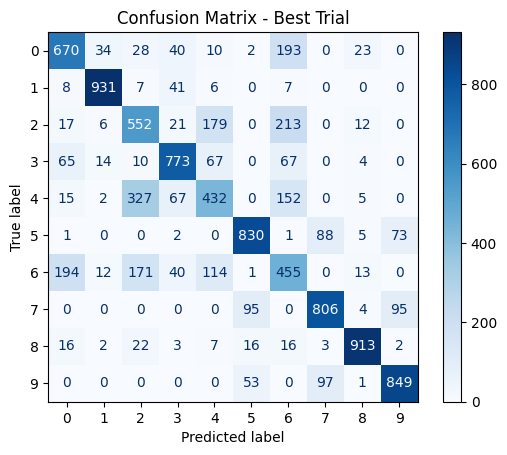

In [8]:
# Load the best model
best_params = study.best_trial.params

# Reset all seeds
set_all_seeds(42)

best_model = BaseCPNN(input_size,
                      best_params['hidden_size'],
                      output_size,
                      neighborhood_function=best_params['neighborhood_function'],
                      neighborhood_size=best_params['neighborhood_size']).to(device)


# Reload the generator to ensure that the loader passes data in the same order
g = torch.Generator()
g.manual_seed(42)

train_loader = DataLoader(full_train_dataset, batch_size=256, shuffle=True, num_workers=8, pin_memory=True,  worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=8, pin_memory=True, worker_init_fn=seed_worker, generator=g)


# Retrain
best_model.fit(device,
               train_loader=test_loader,
               val_loader=test_loader,
               epochs=5,
               kohonen_lr=best_params['kohonen_lr'],
               grossberg_lr=best_params['grossberg_lr'],
               early_stopping=True,
               patience=10)

# Get predictions for the test set
true_labels = []
pred_labels = []

best_model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs, _ = best_model(batch_x)
        preds = outputs.argmax(dim=1).cpu()
        pred_labels.extend(preds.tolist())
        true_labels.extend(batch_y.tolist())

# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(output_size)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Best Trial")
plt.show()

In [9]:
# 1) Imports
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# 2) Build neuron → dominant‐digit labels from your train_loader
act_log = defaultdict(list)
best_model.eval()
with torch.no_grad():
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        _, wins = best_model(X)  # winners: (batch,)
        for n, d in zip(wins.cpu().numpy(), y.cpu().numpy()):
            act_log[n].append(d)

neuron_labels = []
for i in range(best_model.hidden_size):
    votes = act_log.get(i, [])
    if votes:
        neuron_labels.append(int(max(set(votes), key=votes.count)))
    else:
        neuron_labels.append(-1)  # shouldn’t happen often

# 3) Run t‑SNE on each epoch’s Kohonen snapshot
tsne_snapshots = []
for W in best_model.kohonen_snapshots:
    # W: Tensor of shape (n_neurons, input_dim)
    P = TSNE(
        n_components=2,
        random_state=42,
        perplexity=30,
        init='pca',
        learning_rate='auto'
    ).fit_transform(W.cpu().numpy())
    tsne_snapshots.append(P)  # array of shape (n_neurons, 2)

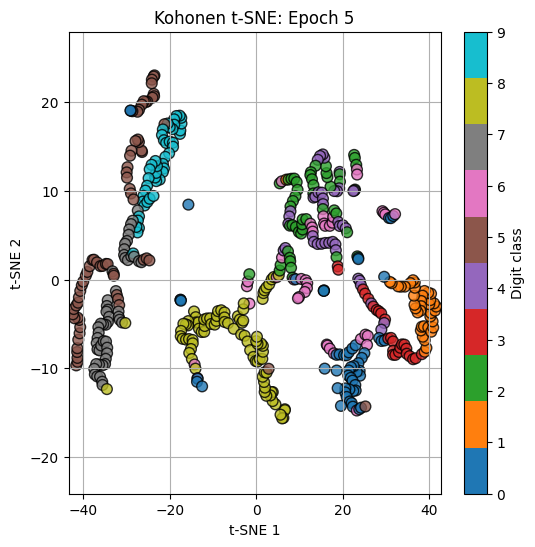

In [10]:
def animate_tsne_kohonen(snapshots, neuron_labels, interval=500):
    """
    snapshots: list of (n_neurons, 2) arrays (t-SNE coords per epoch)
    neuron_labels: length-n_neurons list/array of ints in [0..9]
    """
    cmap   = plt.get_cmap('tab10')
    colors = cmap(neuron_labels)  # shape (n_neurons, 4)

    fig, ax = plt.subplots(figsize=(6,6))

    # tell colorbar which axes to use
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=9))
    fig.colorbar(sm, ax=ax, ticks=range(10), label="Digit class")

    # Initialize with the first snapshot data
    scatter = ax.scatter(snapshots[0][:, 0], snapshots[0][:, 1], s=60, edgecolors='k', alpha=0.8, c=colors)
    title   = ax.set_title("")
    ax.set_xlabel("t‑SNE 1")
    ax.set_ylabel("t‑SNE 2")
    ax.grid(True)

    # fix axes limits so they don't jump
    all_pts = np.vstack(snapshots)
    xmin, xmax = all_pts[:,0].min()-1, all_pts[:,0].max()+1
    ymin, ymax = all_pts[:,1].min()-1, all_pts[:,1].max()+1
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    def init():
        # initialize with the first snapshot data
        scatter.set_offsets(snapshots[0])
        title.set_text("Epoch 0")
        return scatter, title

    def update(frame):
        scatter.set_offsets(snapshots[frame])
        title.set_text(f"Kohonen t‑SNE: Epoch {frame+1}")
        return scatter, title

    ani = animation.FuncAnimation(
        fig, update,
        frames=len(snapshots),
        init_func=init,
        blit=True,
        interval=interval
    )
    return HTML(ani.to_jshtml())

# 5) Display the animation
animate_tsne_kohonen(tsne_snapshots, neuron_labels)